In [32]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras.optimizers import Adadelta
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.layers import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.model_selection import KFold
from IPython.display import clear_output

In [13]:
files = !cd Datasets/20_genomes_species_splitted/50_splitted && ls *.csv
files = list(map(lambda x: 'Datasets/20_genomes_species_splitted/50_splitted/'+x.split(' ')[-1],files))

In [14]:
d = pd.concat([pd.read_csv(f, index_col=0, header=0) for f in files],ignore_index=True)

In [15]:
names, occ = np.unique(d['class'].values, return_counts=True)

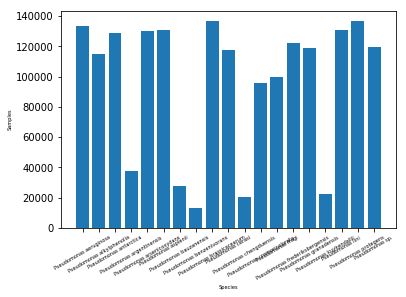

In [16]:
index = np.arange(len(names))
plt.bar(index, occ)
plt.xlabel('Species', fontsize=5)
plt.ylabel('Samples', fontsize=5)
plt.xticks(index,names, fontsize=5, rotation=30)
plt.savefig('dist19.png')
plt.show()

In [17]:
data = d[['class','seq']]

In [18]:
data.sample(10)

,class,seq
1763714,Pseudomonas protegens,TCAAGGACGTCGACCGTGACAGTTTCGACCAGGTGATGCGGCCCAA...
1448561,Pseudomonas sp.,CTCGAAGGCGACTTCATGCAGCATTTCCCGGTGGATATCTTCCAGA...
900518,Pseudomonas cerasi,AGCCTGGACAACCGCAGACCAAGGCGTTGATCGAGCGCATTCGCGA...
343741,Pseudomonas antarctica,CCGGCTGGGAGATGTATATCGGCGGCAATGGCGGGATCAAAACCGA...
596474,Pseudomonas asplenii,TCGATGGCGGCCAAGGCCAACTCACGCACCGTGTGTGCCGATTGCA...
1803207,Pseudomonas protegens,GACACGGTACGCCGCTGCCCATCGTCGCCCTTACCGCCCACGCCAT...
982112,Pseudomonas chengduensis,GAAGACGGGTGATGGCGCCTTGCGCCTTGAATGAGGCGTTGTTGTG...
1395367,Pseudomonas granadensis,CTTGACGCTACCCGCACGGAACAAGGAATACCCCTTTGAAGCTGGA...
546388,Pseudomonas asplenii,GCAGGACGGTAAACCCGCTTATCAGGGGCGTCTGGGCGATACCCTG...
1047631,Pseudomonas cremoricolorata,TGAAGCTTCTCAAATGGCCTTTGCCCGGGTGTCGCAATTGAGCCTG...


In [19]:
current_size = data[data['class']=='Pseudomonas benzenivorans'].shape[0]
print(current_size)

13459


In [73]:
data_pos = data[data['class']=='Pseudomonas benzenivorans']#.sample(int(current_size*0.8)) #80%

In [74]:
if (data[data['class']!='Pseudomonas benzenivorans'].shape[0]-int(current_size)*18)/18 >= 0:
    data_neg = data[data['class']!='Pseudomonas benzenivorans'].sample(int(current_size)*18)
else:
    data_neg = data[data['class']!='Pseudomonas benzenivorans'].sample((data.shape[0]-current_size))

In [75]:
pos_seq = []
lun = 0
for i in range(data_pos.shape[0]):
    if i % 1000 == 0:
        sys.stdout.write('Preproc progress: %f \r' % (i*100/data_pos.shape[0]))
        sys.stdout.flush()
        clear_output(wait=True)
    if data_pos.iloc[i,0].strip() == 'Pseudomonas benzenivorans':
        s = list(map(lambda x: int(ord(x)-65), list(data_pos.iloc[i,1].strip()))) + [data_pos.iloc[i,0].strip()]
    else:
        s = list(map(lambda x: int(ord(x)-65), list(data_pos.iloc[i,1].strip()))) + ['other']
    pos_seq.append(s)
pos_seq = np.asarray(pos_seq)

In [76]:
neg_seq = []
lun = 0
for i in range(data_neg.shape[0]):
    if i % 1000 == 0:
        sys.stdout.write('Preproc progress: %f \r' % (i*100/data_neg.shape[0]))
        sys.stdout.flush()
        clear_output(wait=True)
    if data_neg.iloc[i,0].strip() == 'Pseudomonas benzenivorans':
        s = list(map(lambda x: int(ord(x)-65), list(data_neg.iloc[i,1].strip()))) + [data_neg.iloc[i,0].strip()]
    else:
        s = list(map(lambda x: int(ord(x)-65), list(data_neg.iloc[i,1].strip()))) + ['other']
    neg_seq.append(s)
neg_seq = np.asarray(neg_seq)

In [77]:
from sklearn.preprocessing import LabelBinarizer
X_enc = LabelBinarizer()
X_enc.fit(np.concatenate((neg_seq[:,:-1],pos_seq[:,:-1])).flatten().astype('str'))
y_enc = LabelEncoder()
y_enc.fit(np.concatenate((neg_seq[:,-1],pos_seq[:,-1])))

LabelEncoder()

In [78]:
kfold = KFold(n_splits=5,random_state=7)

In [79]:
split_pos = list(kfold.split(pos_seq[:,:-1],pos_seq[:,-1]))

In [ ]:
split_neg = list(kfold.split(neg_seq[:,:-1],neg_seq[:,-1]))

In [ ]:
for f in range(10):
    pos_train = split_pos[f][0]
    pos_test = split_pos[f][1]
    neg_train = split_neg[f][0]
    neg_test = split_neg[f][1]
    
    X_train = np.concatenate((neg_seq[neg_train,:-1],pos_seq[pos_train,:-1]))
    y_train = np.concatenate((neg_seq[neg_train,-1],pos_seq[pos_train,-1]))
    X_test = np.concatenate((neg_seq[neg_test,:-1],pos_seq[pos_test,:-1]))
    y_test = np.concatenate((neg_seq[neg_test,-1],pos_seq[pos_test,-1]))
    
    X_train = np.asarray(list(map(lambda x: X_enc.transform(x.astype('str')),X_train)))
    X_test = np.asarray(list(map(lambda x: X_enc.transform(x.astype('str')),X_test)))
    
    y_train = y_enc.transform(y_train)
    y_train = np_utils.to_categorical(y_train)
    y_test = y_enc.transform(y_test)
    y_test = np_utils.to_categorical(y_test)
    
    print(X_train.shape)
    print(X_test.shape)

(204576, 250, 5)
(51145, 250, 5)


In [70]:
pos_seq

array([['6', '19', '0', ..., '0', '0', 'Pseudomonas benzenivorans'],
       ['2', '6', '2', ..., '6', '2', 'Pseudomonas benzenivorans'],
       ['2', '0', '19', ..., '0', '0', 'Pseudomonas benzenivorans'],
       ...,
       ['0', '6', '6', ..., '6', '19', 'Pseudomonas benzenivorans'],
       ['6', '19', '2', ..., '6', '2', 'Pseudomonas benzenivorans'],
       ['19', '6', '19', ..., '2', '0', 'Pseudomonas benzenivorans']],
      dtype='<U25')

In [1]:
import pickle

In [2]:
with open('Restults_cv/Pseudomonas_benzenivorans_CV_scores.pkl','rb') as p:
    x = pickle.load(p)

In [8]:
x

[[{'f1': 0.96168940384974777,
   'precision': 0.96765701391500569,
   'recall': 0.95579494799405651},
  {'f1': 0.94579582455468303,
   'precision': 0.97627520759193354,
   'recall': 0.91716196136701333},
  {'f1': 0.94846153846153847,
   'precision': 0.98325358851674638,
   'recall': 0.91604754829123325},
  {'f1': 0.95108077360637089,
   'precision': 0.97134004647560035,
   'recall': 0.93164933135215455},
  {'f1': 0.94842300556586268,
   'precision': 0.94701741385698401,
   'recall': 0.94983277591973247}],
 [array([[ 2573,   119],
         [   86, 48367]]), array([[ 2469,   223],
         [   60, 48393]]), array([[ 2466,   226],
         [   42, 48410]]), array([[ 2508,   184],
         [   74, 48378]]), array([[ 2556,   135],
         [  143, 48309]])],
 [[0.18561426713105875,
   0.14751075248321527,
   0.12013838103393013,
   0.095376753106456325,
   0.073917908616118966,
   0.055635968749714416,
   0.040854778053667572,
   0.029888716180944033,
   0.021368820845210933,
   0.015436589